# Classification using a Support Vector Machine (SVM)

Multivariate pattern analysis (MVPA) has emerged as a powerful tool in human electrophysiological research, enabling the investigation of representational content encoded in spatially distributed patterns of brain activity [1,3]. Unlike traditional univariate approaches, which examine changes in activity at individual sensors or regions, MVPA leverages the combined information across multiple channels to detect subtle and spatially distributed neural representations. In the present example, we illustrate how a support vector machine (SVM) classifier can be used to decode brain activity patterns associated with lateralised cue processing—specifically, to discriminate between neural responses elicited by left- versus right-sided cues.

## Preparation

Below are the required Python modules to be imported

In [1]:
import os.path as op
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne_bids import BIDSPath
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import sklearn.svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

The classification is based on the tools in the *Scikit-Learn* package.

## File overview

The chapter relies on the input file (embedded in the BIDS structure):

`< BIDS_ROOT >/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif`

Set the paths for the data and results. Note that these will depend on your local setup.


## Specify your BIDS parameters along with the BIDS folder path

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'  
run = '01'  
meg_suffix = 'meg'
epo_suffix = 'epo'

#data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif'

bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/analysis")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)
print(bids_path.basename,bids_path.fpath)

sub-01_ses-01_task-SpAtt_run-01_epo.fif /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif


## Reading and preparing the trial based data

Read the epochs:

In [3]:
epochs = mne.read_epochs(bids_path.fpath,
                         preload=True,
                         verbose=True).pick(['meg'])

Reading /Users/o.jensen@bham.ac.uk/Data/CercaOxf/fif/Cerca_Spatt_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif ...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 180) active
        HFC: l=1 m=0 (1 x 180) active
        HFC: l=1 m=1 (1 x 180) active
        HFC: l=2 m=-2 (1 x 180) active
        HFC: l=2 m=-1 (1 x 180) active
        HFC: l=2 m=0 (1 x 180) active
        HFC: l=2 m=1 (1 x 180) active
        HFC: l=2 m=2 (1 x 180) active
    Found the data of interest:
        t =    -749.33 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
219 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated


Now filter the data. In this case we bandpass the data from 1 to 45 Hz. This is done before cutting the trials in shorter segments in order to reduce edge effects from the filtering. The filter also serves to perform temporal smoothing of the data which will benefit the classification.

In [4]:
epochs_rs = epochs.copy().filter(1,45)

Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 2475 samples (3.300 s)



/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_85194/93604412.py:1: RuntimeWarning: filter_length (2475) is longer than the signal (2063), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_rs = epochs.copy().filter(1,45)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.7s
[

Down-sample the data to 125 Hz in order to reduce the computation time of the classification. Then set the time-window of interest to -0.1 to 1.5 s around the cue onset.

In [5]:
epochs_rs.resample(125)
epochs_rs.crop(tmin=-0.1, tmax=1.5)

<EpochsFIF | 219 events (all good), -0.093 – 1.507 s (baseline off), ~66.0 MiB, data loaded,
 'cue_Left': 113
 'cue_Right': 106>

## Setting up the Classifier

The SVM is implemented in the *Scikit-Learn* package and the corresponding application programming interface (API) must be applied. The matrix `X`
(features) is a three-dimensional matrix (*trials* x *sensors* x *samples*).

In [6]:
X = epochs_rs.get_data(picks='meg') 
X.shape

(219, 180, 201)

In this case we have 219 trials and each trial has 201 samples (time points). The vector *y* (target) contains 113 left trials and 106 right trials. The trial codes (5 & 6) needs to converted to the class labels 1 & 2.

In [8]:
epochs.events[:10,:]

array([[ 90367,      0,      5],
       [ 94080,      0,      5],
       [ 97880,      0,      5],
       [101692,      0,      6],
       [105542,      0,      5],
       [112967,      0,      5],
       [116580,      0,      5],
       [127530,      0,      6],
       [146117,      0,      5],
       [153467,      0,      5]], dtype=int32)

In [9]:
temp = epochs.events[:, 2]
temp[epochs.events[:,2] == 5] = 1
temp[epochs.events[:,2] == 6] = 2
y = temp
print(y)

[1 1 1 2 1 1 1 2 1 1 2 1 1 2 2 2 2 2 1 1 2 2 1 1 2 1 1 1 1 2 2 2 1 1 2 1 2
 1 1 2 1 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 1 2 2 1 1 2 2 2 1 2 1 2 1 2 2 2 2 2
 1 2 2 1 2 1 2 1 1 1 1 1 2 2 2 1 1 1 2 2 1 2 1 1 1 2 2 1 1 1 1 2 1 1 1 2 2
 1 2 1 1 1 2 1 1 2 2 2 1 1 1 2 1 1 1 2 2 1 1 2 1 1 1 2 1 1 1 2 2 2 2 2 2 1
 2 2 2 1 2 2 2 1 2 2 2 1 2 1 2 1 1 1 2 1 1 2 2 1 1 2 1 2 2 1 2 2 2 1 1 1 1
 2 1 2 1 1 2 1 2 1 2 2 2 2 2 2 1 1 2 2 2 2 1 1 1 1 2 1 2 2 2 2 1 1 1]


The function `make_pipeline` is from [Scikit-Learn](https://scikit-learn.org/) . It defines the transforms used with the estimator. The `Vectorizer()` transforms `X` into a 2D array (samples by features). The `StandardScaler()` standardize the data by removing the mean and scaling to unit variance.

In [10]:
clf = make_pipeline(Vectorizer(),StandardScaler(),  
                   LinearModel(sklearn.svm.SVC(kernel = 'linear')))   

Finally the estimator must be defined. We here apply the `SlidingEstimator` that uses the features `X` and targets `y` as input as well as `clf` defining the pipeline. The aim is to discriminate the experimental conditions as functions of time; i.e. at which time points can we tell left from right attention?

In [11]:
time_decod = SlidingEstimator(clf, n_jobs=-1, scoring='roc_auc', verbose=True)

## Performing the Classification

The classification will be performed timepoint by timepoint using a SVM. A 10-fold cross-validation is used where the classifier is traines on 90% of the trials and tested on the remaining 10% trials. This done in 10 runs (cv=10). The output will be reported as Area Under the Curve (AUC).

In [12]:
scores = cross_val_multiscore(time_decod, X, y, cv=10, n_jobs=-1, verbose = False)

## Plotting the Results

In order to plot the results,average over scores and plot

In [13]:
scores = np.mean(scores, axis=0)

Text(0.5, 1.0, 'Sensor space decoding OPM data')

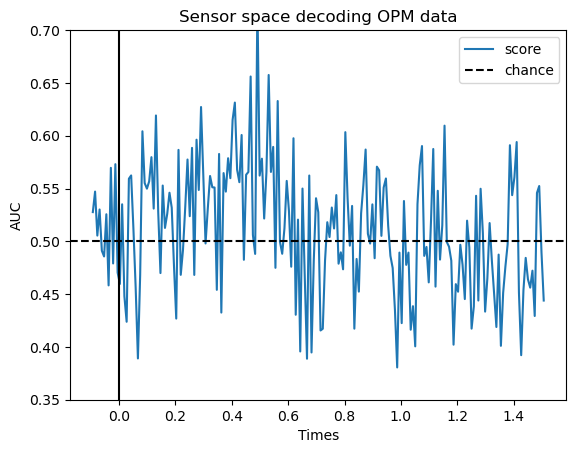

In [14]:
fig, ax = plt.subplots()
plt.ylim([0.35, 0.70])
ax.plot(epochs_rs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding OPM data')

The plots show the accuracy (AUC) of the classification as a function of time. The best classiciation is obtained ~400 ms after the target onset and is about 0.65.

## Preregistration and publications

Publication, example:

"A multi-variate pattern analysis was applied to the OPM-MEG data to classify whether the participants attended left or right. The data were bandpass filtered between 1-45 Hz and then downsampled to 125 Hz. The time-points in the interval -0.1 to 0.5 s around the target onset was considered. The data were standardized by removing the mean and scaling to unit variance per sensor. A support vector machine [2] from Scikit-learn (https://scikit-learn.org/) was applied to classify the data as a function of time. A 10-fold cross-validation procedure was used and the classification rate was reported as Area Under the Curve."

## References

1. Cichy, R. M., Pantazis, D., & Oliva, A. (2014). Resolving human object recognition in space and time. *Nature Neuroscience*, 17(3), 455–462. https://doi.org/10.1038/nn.3635

2. Cortes, C., & Vapnik, V. (1995). Support-vector networks. *Machine Learning*, 20, 273–297.

3. Stokes, M. G., Wolff, M. J., & Spaak, E. (2015). Decoding rich spatial information with high temporal resolution. *Trends in Cognitive Sciences*, 19(11), 636–638. https://doi.org/10.1016/j.tics.2015.08.016

4. Duda, R. O., & Hart, P. E. (2006). *Pattern Classification* (2nd ed.). John Wiley & Sons.

